In [42]:
import spacy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Louvain community detection
import community.community_louvain as community_louvain


In [44]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load cleaned dataset
df = pd.read_csv("C:\\Users\\Praveen\\OneDrive\\Desktop\\fake news detection\\data\\preprocessed data\\cleaned_fakenews.csv")


print("Dataset shape:", df.shape)
df.head()

Dataset shape: (16310, 4)


,title,text,target,final_text
0,Trump to nominate Textron executive for Pentag...,WASHINGTON (Reuters) - U.S. President Donald T...,1,trump nominate textron executive pentagon acqu...
1,Trump renews threat to scrap NAFTA going into ...,WASHINGTON (Reuters) - U.S. President Donald T...,1,trump renews threat scrap nafta going next rou...
2,Twitter Mocks The Hell Out Of Trump For Lates...,"When Trump promised to drain the swamp, he s...",0,twitter mocks hell trump latest poorlyspelled ...
3,France’s President Threw AWESOME Shade At Tru...,French President Emmanuel Macron wasted no tim...,0,france’s president threw awesome shade trump p...
4,Trump Judicial Nominee: Transgender Children ...,Donald Trump s nominee for a federal judgeship...,0,trump judicial nominee transgender children pa...


In [45]:
# Use only a small sample for graph clarity
sample_texts = (
    df["final_text"]
    .dropna()
    .sample(60, random_state=42)
    .tolist()
)

len(sample_texts)

60

In [46]:
def extract_relations(text):
    doc = nlp(text)
    relations = []

    for token in doc:
        if token.pos_ == "VERB" and token.dep_ in ("ROOT", "relcl"):
            subject = [
                w.text for w in token.lefts
                if w.dep_ in ("nsubj", "nsubjpass")
            ]
            obj = [
                w.text for w in token.rights
                if w.dep_ in ("dobj", "pobj")
            ]

            if subject and obj:
                relations.append((subject[0], token.lemma_, obj[0]))

    return relations

In [47]:
all_relations = []

for text in sample_texts:
    if isinstance(text, str):
        all_relations.extend(extract_relations(text))

print("Total relations extracted:", len(all_relations))
all_relations[:10]

Total relations extracted: 45


[('warren', 'slap', 'hell'),
 ('party', 'carry', 'betfair'),
 ('trump', 'push', 'ban'),
 ('man', 'arrest', 'pointing'),
 ('weapon', 'get', 'deputy'),
 ('photographer', 'take', 'realdonaldtrump'),
 ('talks', 'tell', 'effort'),
 ('moscow', 'reuter', 'accusations'),
 ('trump', 'shake', 'hands'),
 ('withdrawtrump', 'interpret', 'mit')]

In [54]:
G = nx.Graph()

BAD_NODES = {
    "he","she","it","they","them","who","that","which","this","we","i","you"
}

for head, relation, tail in all_relations:
    if head.lower() not in BAD_NODES and tail.lower() not in BAD_NODES:
        G.add_edge(head, tail, label=relation)

print("Initial nodes:", G.number_of_nodes())
print("Initial edges:", G.number_of_edges())



Initial nodes: 77
Initial edges: 43


In [55]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

print("Top 5 Degree Centrality:")
sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

Top 5 Degree Centrality:


[('trump', 0.06578947368421052),
 ('democrats', 0.039473684210526314),
 ('china', 0.02631578947368421),
 ('politicians', 0.02631578947368421),
 ('russia', 0.02631578947368421)]

In [56]:
degree_centrality = nx.degree_centrality(G)

TOP_N = 120   # 🔥 IMPORTANT CHANGE

top_nodes = sorted(
    degree_centrality,
    key=degree_centrality.get,
    reverse=True
)[:TOP_N]

G = G.subgraph(top_nodes).copy()

print("Final nodes:", G.number_of_nodes())



Final nodes: 77


In [57]:
partition = community_louvain.best_partition(G)

print("Sample community assignments:")
list(partition.items())[:10]

Sample community assignments:


[('warren', 1),
 ('hell', 1),
 ('party', 3),
 ('betfair', 3),
 ('trump', 4),
 ('ban', 4),
 ('man', 7),
 ('pointing', 7),
 ('weapon', 8),
 ('deputy', 8)]

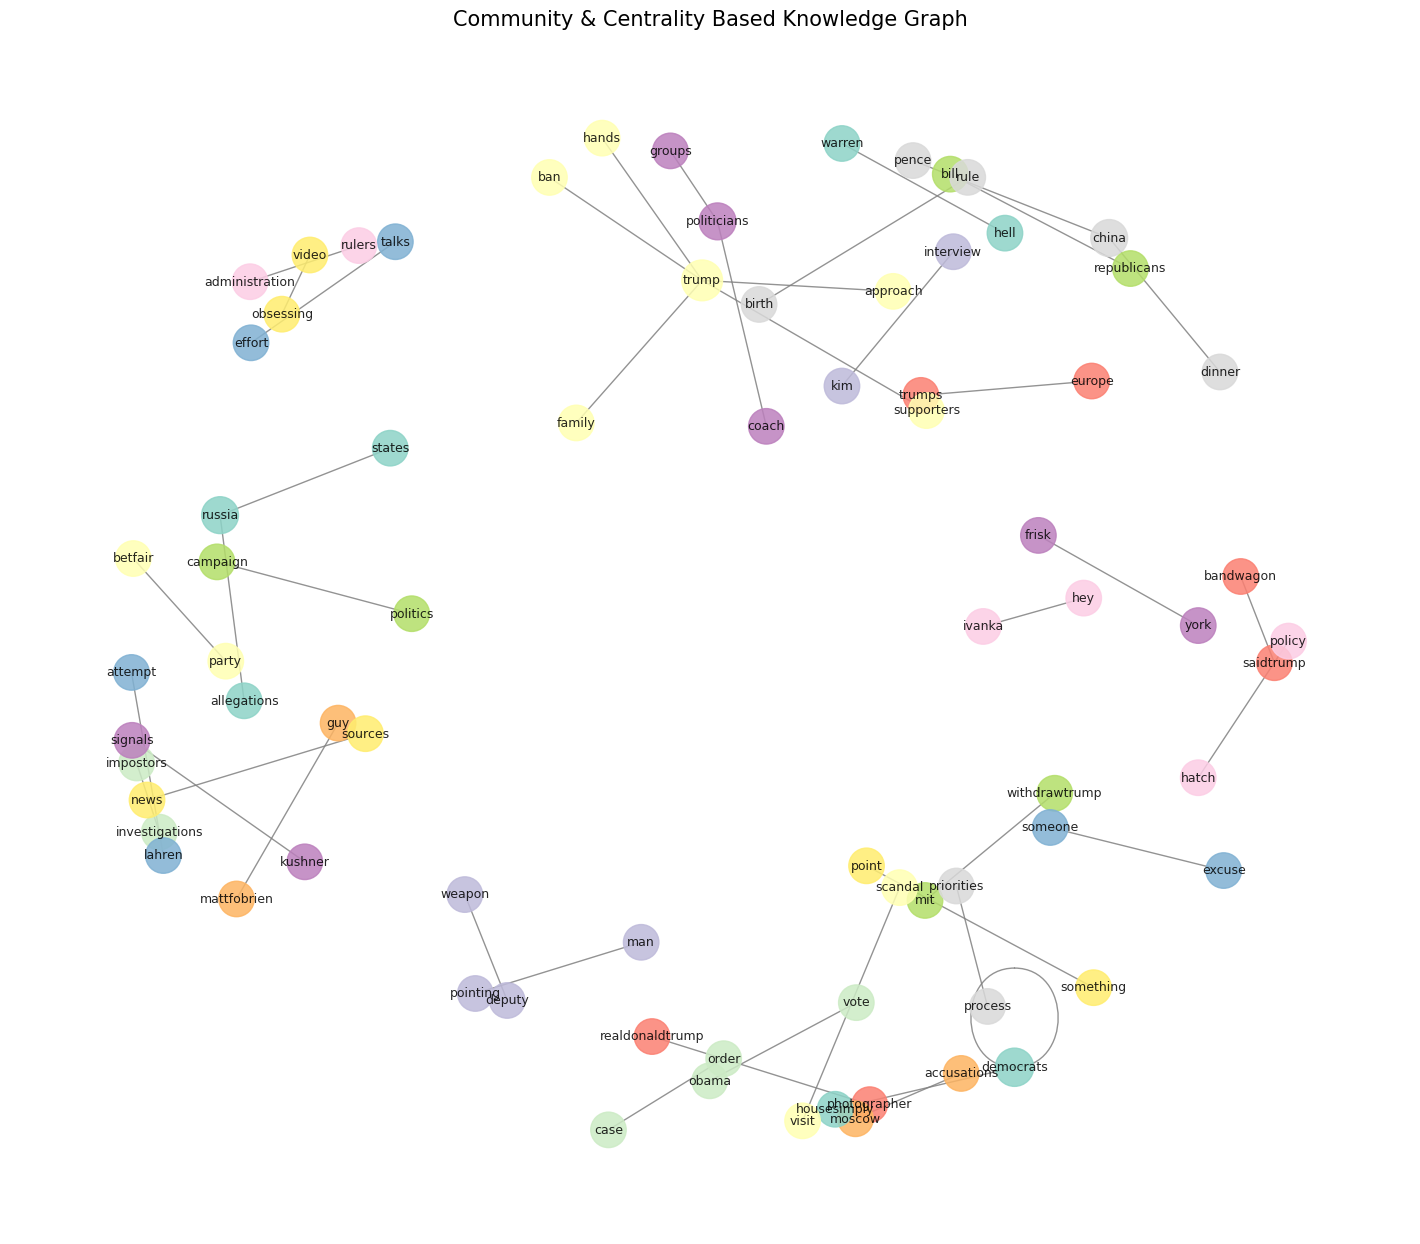

In [58]:
plt.figure(figsize=(14, 12))

pos = nx.spring_layout(G, seed=42, k=0.8, iterations=100)

node_sizes = [
    600 + 4000 * degree_centrality.get(node, 0)
    for node in G.nodes()
]

node_colors = [partition[node] for node in G.nodes()]

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.Set3,
    font_size=9,
    edge_color="gray",
    alpha=0.85
)

plt.title("Community & Centrality Based Knowledge Graph", fontsize=15)
plt.show()
